This Notebook presents the application of the Equivalent Layer technique using a regular-spaced grid of aeromagnetic data at Carajas, Para, Brazil. 

To achieve high efficiency in property estimative of the equivalent sources, the method CGLS for inversion was used, combined with a fast matrix-vector product only possible because of the Block-Toeplitz Toeplitz-Block(BTTB) structure of the sensitivity matrix. 

The total number of data is 7,706,153. For this case we gridded the data up to 2,500,000 observation points, which means that for storing the full sensitivity matrix it would be necessary 45.47 Terabytes of RAM. However, taking advantage that the second derivatives of $1/r$ are symmetric or skew-symmetric matrices, it is possible to reconstruct the whole sensitivity matrix storing only the first row or column of each component (Hxx, Hxy, Hxz, Hyy, Hyz, Hzz), thus, using only 114.44 Megabytes.

Alternatively, using the nonsymmetric BTTB structure of the sensitivity matrix, it is possible to store only the first and last columns (or rows) of the first and last columns (or rows) of blocks of the matrix. Thus, the storage is reduced to 76.29 Megabytes.

This fast matrix-vector product also is used for data processing (upward continuation) in a very efficient way, making it possible to process 2,500,000 data for upward continuation in half a second.

### Import

In [2]:
import numpy as np
import functions_eq_mag as fc
from timeit import default_timer as time
import sys
sys.path.append('C:/ProgramData/Anaconda2/Lib/site-packages/fatiando')
from fatiando import mesher, gridder, utils
from fatiando.vis import mpl
from scipy.interpolate import griddata
from scipy import interpolate, signal
import cPickle as pickle
from matplotlib import pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

C:\ProgramData\Anaconda2\Lib\site-packages\fatiando\fatiando\vis\mpl.py:70: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


### Observed Grid and Data

In [3]:
with open('carajas_tf.pickle') as r:
    carajas = pickle.load(r)

In [4]:
xi = carajas['x']
yi = carajas['y']
zi = carajas['z']
dobs = carajas['tf']
shape_m = (500, 500)
N = shape_m[0]*shape_m[1]

### Plot the gridded data of Carajas, Brasil

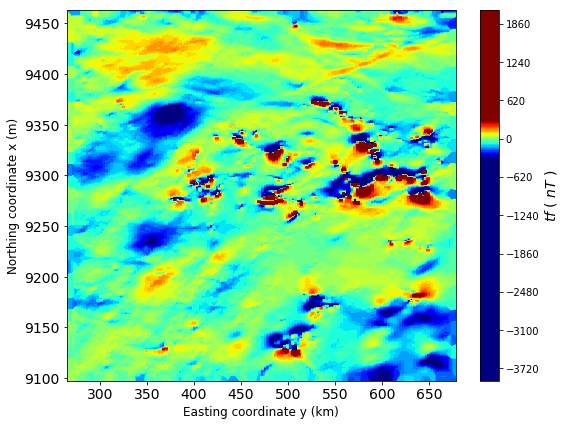

In [5]:
plt.figure(figsize=(8,6))
plt.plot()
plt.tricontourf(yi, xi, dobs, 300, vmin=-300, vmax=300, cmap='jet')
#cb = plt.colorbar(shrink=0.825)
cb = plt.colorbar()
#plt.axis('scaled')
cb.set_label('$tf$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=12)
plt.ylabel('Northing coordinate x (m)', fontsize=12)
mpl.m2km()
plt.tight_layout(True)
#plt.savefig('figures/carajas_real_data.png', dpi=300)

## Equivalent layer Depth

In [6]:
# Equivalent Layer depth
zj = np.ones_like(zi) * -300

## Magnetic configuration

As this area is very large different values of the magnetic main field can be considered. 
The main field declination was calculated using the tool in the website (for the date 01/01/2014): https://www.ngdc.noaa.gov/geomag/calculators/magcalc.shtml

When the latitude is -5° and longitude -53° the declination is -18.89°.

When the latitude is -8° and longitude -53° the declination is -18.97°.

When the latitude is -5° and longitude -50.5° the declination is -19.86°.

When the latitude is -8° and longitude -50.5° the declination is -20.04°.

For this test I considered an approximated mid location of the area (latitude -6.5° and longitude -50.75°). The declinations is -19.48°.

The inclination was calculated considering the Geocentric axial dipole model ($tang \, I = 2 \times tan \, \lambda$).

The source magnetization is unknown. Inclination and declination equal to the main field is being used.

In [7]:
inc0 = np.rad2deg(np.arctan(2*np.tan(np.deg2rad(6.5))))
inc0

12.836868528199744

In [8]:
# Magnetic Configuration
inc0 = np.deg2rad(inc0)
dec0 = np.deg2rad(-19.48)
inc = np.deg2rad(inc0)
dec = np.deg2rad(-19.48)

# Main field magnetization cosines direction
F = np.array([np.cos(inc0) * np.cos(dec0), np.cos(inc0) * np.sin(dec0), np.sin(inc0)])

# Equivalent sources magnetization cosines direction
h = np.array([np.cos(inc)*np.cos(dec), np.cos(inc)*np.sin(dec), np.sin(inc)])

## Fast Eq. Layer Combined with Circulant-Toeplitz (BCCB)

In [9]:
w = time()
itmax = 50
p_lsqr, dobs_lsqr = fc.cgls_eq_bccb_mag(xi, yi, zi,zj, shape_m, dobs, F, h, itmax)
t = time()
tcpu = t - w
print tcpu

15.6621324


## Property estimative plot

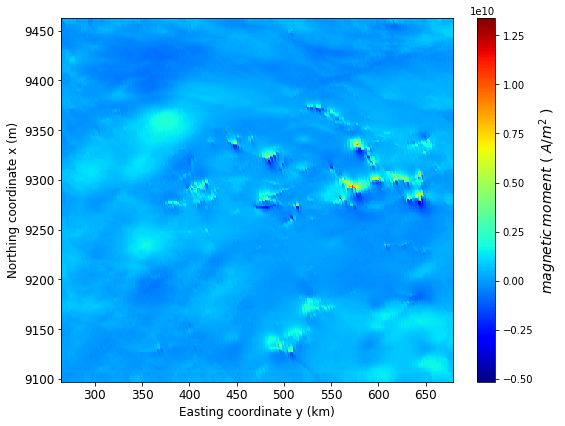

In [10]:
plt.figure(figsize=(8, 6))

plt.plot()
plt.pcolormesh(yi.reshape(shape_m), xi.reshape(shape_m), p_lsqr.reshape(shape_m), cmap='jet')
cb = plt.colorbar()
cb.set_label('$magnetic \, moment$ ( $A/m^2$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi), np.max(yi))
plt.ylim(np.min(xi), np.max(xi))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Easting coordinate y (km)', fontsize=12)
plt.ylabel('Northing coordinate x (m)', fontsize=12)
mpl.m2km()
plt.tight_layout(True)
#plt.savefig('figures/rho_carajas_500x500.png', dpi=300)
plt.show()

## Data, Predicted data and Residuals plot

## Fast Equivalent layer BCCB plot

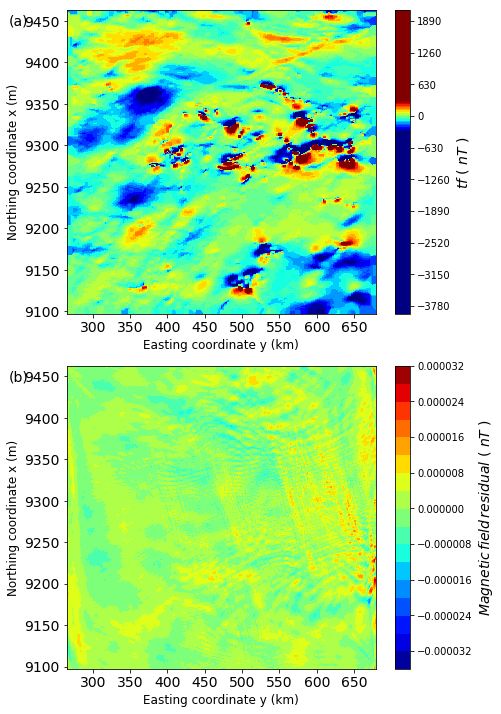

In [11]:
# plot of the total field anomaly at z=900 
plt.figure(figsize=(7, 10))

plt.subplot(211)
plt.title('(a)', y=0.93, x=-0.155, fontsize=14)
plt.tricontourf(yi, xi, dobs_lsqr, 200, vmin=-300, vmax=300, cmap='jet')
cb = plt.colorbar()
cb.set_label('$tf$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=12)
plt.ylabel('Northing coordinate x (m)', fontsize=12)
mpl.m2km()

delta_dobs = dobs_lsqr - dobs
plt.subplot(212)
plt.title('(b)', y=0.93, x=-0.155, fontsize=14)
plt.tricontourf(yi, xi, delta_dobs, 15, cmap='jet')
cb = plt.colorbar()
cb.set_label('$Magnetic \, field \, residual$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=12)
plt.ylabel('Northing coordinate x (m)', fontsize=12)
mpl.m2km()
plt.tight_layout(True)
#plt.savefig('figures/carajas_gz_predito_val.png', dpi=300)

In [12]:
mean = np.mean(delta_dobs)
print mean
std = np.std(delta_dobs)
print std

-2.7134751243137856e-07
3.2725945791318023e-06


### Convergence analysis

In [232]:
# Apenas rode se tiver 30 minutos pra esperar!!!
itmax = np.arange(1, 120, 10)
res_list_ls = []
for k in itmax:
    p_lsqr_conv, dobs_lsqr_conv = fc.lsqr_eq_bccb_mag_tikho_0(xi, yi,zi, zj, shape_m, dobs, F, h, k)
    norm_res_ls = np.linalg.norm(dobs - dobs_lsqr_conv)
    res_list_ls.append(norm_res_ls)

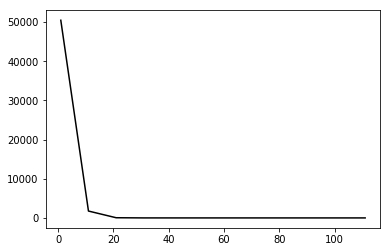

In [233]:
plt.plot(itmax,res_list_ls, 'k-')

## Transformation - Upward Continuation

### 2000 meters

In [13]:
# BTTB Eq. Layer Transformation
z_up = np.zeros_like(xi) - 2000

bttb_0_up, bttb_1_up, bttb_2_up, bttb_3_up = fc.bttb_mag(xi, yi, z_up, zj, F, h, shape_m)
cev_up = fc.cev_mag(bttb_0_up, bttb_1_up, bttb_2_up, bttb_3_up, shape_m, N)
tf_bccb_up = fc.fast_forward_bccb_mag(cev_up, p_lsqr, shape_m, N)

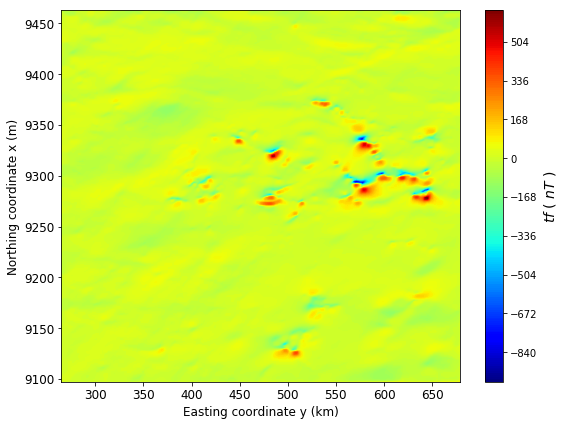

In [14]:
# plot of the vertical component of the gravitational atraction at z=0 
plt.figure(figsize=(8, 6))

plt.tricontourf(yi, xi, tf_bccb_up, 200, cmap='jet')
cb = plt.colorbar()
#plt.axis('scaled')
cb.set_label('$tf$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi), np.max(yi))
plt.ylim(np.min(xi), np.max(xi))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Easting coordinate y (km)', fontsize=12)
plt.ylabel('Northing coordinate x (m)', fontsize=12)
mpl.m2km()
plt.tight_layout(True)
#plt.savefig('figures/up2000_carajas_500x500.png', dpi=300)
plt.show()

### 3500 meters

In [15]:
# BTTb Eq. Layer Transformation
z_up = np.zeros_like(xi) - 3500
s = time()
bttb_0_up, bttb_1_up, bttb_2_up, bttb_3_up = fc.bttb_mag(xi, yi, z_up, zj, F, h, shape_m)

cev_up = fc.cev_mag(bttb_0_up, bttb_1_up, bttb_2_up, bttb_3_up,shape_m,N)

tf_bccb_up = fc.fast_forward_bccb_mag(cev_up,p_lsqr,shape_m,N)
e = time()
tcpu = e - s
print tcpu

0.4574457


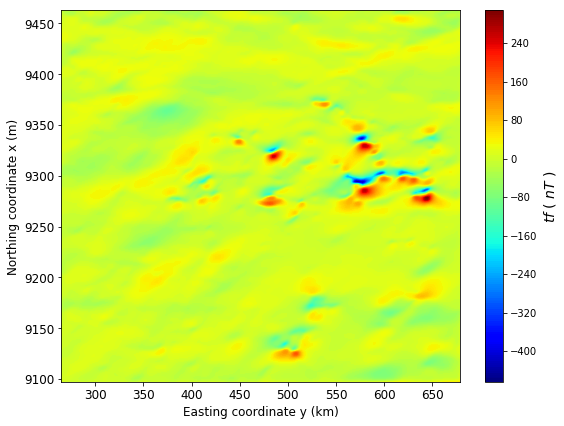

In [16]:
# plot of the vertical component of the gravitational atraction at z=0 
plt.figure(figsize=(8, 6))

plt.tricontourf(yi, xi, tf_bccb_up, 200, cmap='jet')
cb = plt.colorbar()
#plt.axis('scaled')
cb.set_label('$tf$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi), np.max(yi))
plt.ylim(np.min(xi), np.max(xi))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Easting coordinate y (km)', fontsize=12)
plt.ylabel('Northing coordinate x (m)', fontsize=12)
mpl.m2km()
plt.tight_layout(True)
#plt.savefig('figures/up3500_carajas_500x500.png', dpi=300)
plt.show()

### 5000 meters

In [17]:
# BTTb Eq. Layer Transformation
z_up = np.zeros_like(xi) - 5000
s = time()
bttb_0_up, bttb_1_up, bttb_2_up, bttb_3_up = fc.bttb_mag(xi, yi, z_up, zj, F, h, shape_m)

cev_up = fc.cev_mag(bttb_0_up, bttb_1_up, bttb_2_up, bttb_3_up, shape_m, N)

tf_bccb_up = fc.fast_forward_bccb_mag(cev_up, p_lsqr, shape_m, N)
e = time()
tcpu = e - s
print tcpu

0.4579995


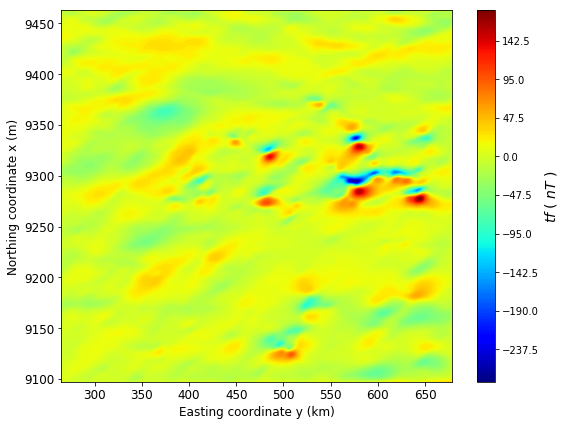

In [18]:
# plot of the vertical component of the gravitational atraction at z=0 
plt.figure(figsize=(8, 6))

plt.tricontourf(yi, xi, tf_bccb_up, 200, cmap='jet')
cb = plt.colorbar()
#plt.axis('scaled')
cb.set_label('$tf$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi), np.max(yi))
plt.ylim(np.min(xi), np.max(xi))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Easting coordinate y (km)', fontsize=12)
plt.ylabel('Northing coordinate x (m)', fontsize=12)
mpl.m2km()
plt.tight_layout(True)
#plt.savefig('figures/up5000_carajas_500x500.png', dpi=300)
plt.show()